## Figure 1

Percent replicating for L1000 and Cell Painting Assays

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure1")
extensions <- c(".png", ".pdf")

### Panel A - Within assay percent replicating non-parametric p values

In [3]:
# The threshold indicats above the 95% percentile of carefully-controlled null distribution
threshold <- 0.05
plot_thresh <- -log10(threshold)

results_dir <- file.path("../1.Data-exploration/Profiles_level4/")
well_specific_null <- TRUE

In [4]:
cell_painting_pr_pval <- load_percent_replicating_nonparametric_pvals(
    assay="cellpainting",
    results_dir=results_dir,
    cp_file_indicator="",
    well_specific_null=well_specific_null
)

l1000_pr_pval <- load_percent_replicating_nonparametric_pvals(
    assay="l1000",
    results_dir=results_dir,
    l1000_file_indicator="",
    well_specific_null=well_specific_null
)

if (well_specific_null) {
    pr_pval_df <- dplyr::bind_rows(
        cell_painting_pr_pval %>%
            dplyr::mutate(
                assay="Cell Painting",
                normalization="spherized",
                category="all_data"
            ),
        l1000_pr_pval %>%
            dplyr::mutate(
                assay="L1000",
                normalization="non_spherized",
                category="all_data"
            )
    ) %>%
        dplyr::mutate(pass_thresh = p_value < threshold) %>%
        dplyr::mutate(neg_log_10_p_val = -log10(p_value)) %>%
        dplyr::mutate(dose = dose_recode)
    
    pr_pval_df$dose <- dplyr::recode_factor(pr_pval_df$dose_recode, !!!dose_rename)
    pr_pval_df$dose <- factor(pr_pval_df$dose, levels = dose_order)
    pr_pval_df$neg_log_10_p_val[pr_pval_df$neg_log_10_p_val == Inf] = 3.5
    
} else {
    pr_pval_df <- dplyr::bind_rows(
        cell_painting_pr_pval,
        l1000_pr_pval
    ) %>%
        dplyr::mutate(pass_thresh = p_value < threshold) %>%
        dplyr::mutate(neg_log_10_p_val = -log10(p_value))

    pr_pval_df$dose <- factor(pr_pval_df$dose, levels = dose_order)
    pr_pval_df$neg_log_10_p_val[pr_pval_df$neg_log_10_p_val == Inf] = 3.5
}


# Note, this number of compounds represents:
# "how many compounds were measured in both assays at ALL doses".
print(length(unique(pr_pval_df$compound)))

print(dim(pr_pval_df))
head(pr_pval_df)

[1] 1258
[1] 15138    12


compound,no_of_compounds,well,dose_recode,median_score,p_value,assay,normalization,category,pass_thresh,neg_log_10_p_val,dose
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<fct>
17-hydroxyprogesterone-caproate,5,N18,1,0.05455739,0.009,Cell Painting,spherized,all_data,TRUE,2.0457575,0.04 uM
2-iminobiotin,5,B12,1,0.05379096,0.004,Cell Painting,spherized,all_data,TRUE,2.3979400,0.04 uM
3-amino-benzamide,5,D24,1,0.11193277,0.001,Cell Painting,spherized,all_data,TRUE,3.0000000,0.04 uM
3-deazaadenosine,5,O12,1,0.01575401,0.322,Cell Painting,spherized,all_data,FALSE,0.4921441,0.04 uM
abacavir,5,J06,1,0.01567809,0.382,Cell Painting,spherized,all_data,FALSE,0.4179366,0.04 uM
abiraterone-acetate,5,C18,1,0.12440335,0.000,Cell Painting,spherized,all_data,TRUE,3.5000000,0.04 uM


In [5]:
table(pr_pval_df$no_of_compounds, pr_pval_df$assay)

   
    Cell Painting L1000
  2           300   487
  3             0  6802
  4           319   277
  5          6953     0

In [6]:
percent_replicating_df <- pr_pval_df %>%
    dplyr::group_by(assay, dose) %>%
    dplyr::mutate(percent_replicating = paste0(100 * round((sum(pass_thresh) / length(pass_thresh)), 2), "%")) %>%
    dplyr::select(dose, assay, percent_replicating) %>%
    dplyr::distinct()

percent_replicating_df

dose,assay,percent_replicating
<fct>,<chr>,<chr>
0.04 uM,Cell Painting,57%
0.12 uM,Cell Painting,56%
0.37 uM,Cell Painting,61%
1.11 uM,Cell Painting,66%
3.33 uM,Cell Painting,74%
10 uM,Cell Painting,83%
0.04 uM,L1000,16%
0.12 uM,L1000,17%
0.37 uM,L1000,20%


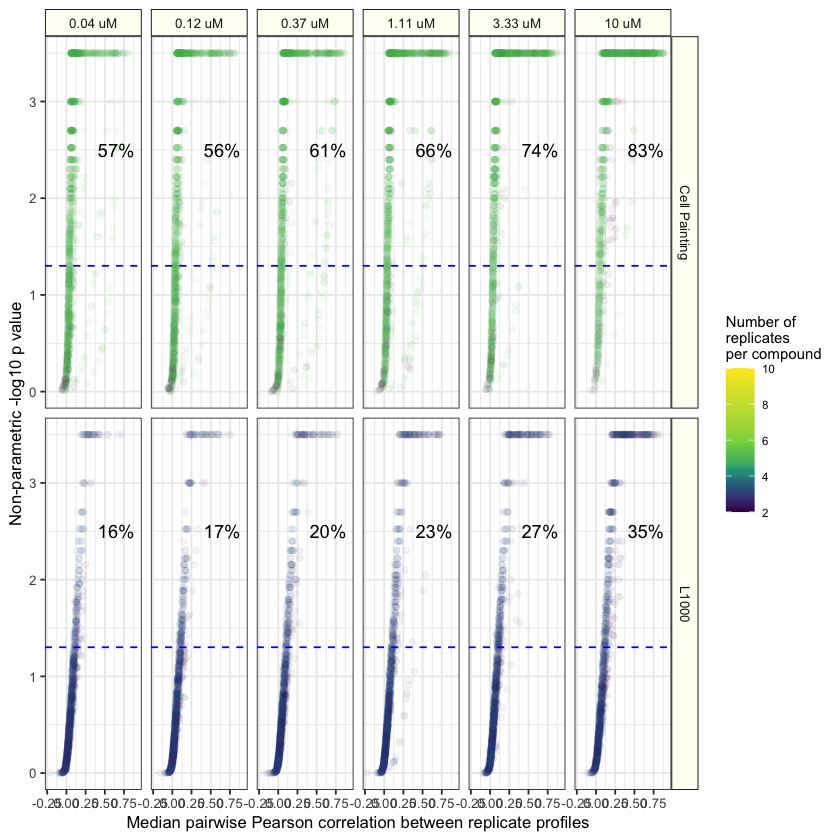

In [7]:
panel_a_gg <- (
    ggplot(pr_pval_df, aes(x = median_score, y = neg_log_10_p_val))
    + geom_point(aes(color = no_of_compounds), alpha = 0.05)
    + geom_text(data = percent_replicating_df, aes(label = percent_replicating, x = 0.65, y = 2.5))
    + facet_grid("assay~dose")
    + geom_hline(linetype = "dashed", color = "blue", yintercept = plot_thresh)
    + theme_bw()
    + figure_theme
    + scale_color_continuous(
        "Number of\nreplicates\nper compound",
        values = scales::rescale(c(0, 0.5, 1, 1.5, 2, 3, 6)),
        limits = c(2, 10),
        type = "viridis"
    )
    + xlab("Median pairwise Pearson correlation between replicate profiles")
    + ylab("Non-parametric -log10 p value")
)

panel_a_gg

## Panel B - Comparing percent replicating scores

At the perturbation level between the two assays.

In [8]:
pr_summary_df <- pr_pval_df %>%
    dplyr::select(compound, dose, well, assay, normalization, category, median_score) %>%
    dplyr::distinct() %>%
    reshape2::dcast(compound + dose + well ~ assay + normalization + category, value.var = "median_score")  %>%
    dplyr::left_join(
        pr_pval_df %>%
            dplyr::filter(assay == "Cell Painting") %>%
            dplyr::select(compound, dose, well, no_of_compounds, pass_thresh, p_value, neg_log_10_p_val),
        by = c("compound", "dose", "well")
    ) %>%
    dplyr::left_join(
        pr_pval_df %>%
            dplyr::filter(assay == "L1000") %>%
            dplyr::select(compound, dose, well, no_of_compounds, pass_thresh, p_value, neg_log_10_p_val),
        by = c("compound", "dose", "well"),
        suffix = c("_cp", "_l1000")
    ) %>%
    dplyr::rename(
        `median_pairwise_correlation_cp` = `Cell Painting_spherized_all_data`,
        `median_pairwise_correlation_l1000` = `L1000_non_spherized_all_data`
    ) %>%
    dplyr::mutate(pass_both = pass_thresh_cp + pass_thresh_l1000) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE)) %>%
    dplyr::select(
        compound,
        well,
        dose,
        median_pairwise_correlation_cp,
        median_pairwise_correlation_l1000,
        pass_thresh_cp,
        pass_thresh_l1000,
        pass_both
    ) %>%
    dplyr::group_by(compound) %>%
    dplyr::mutate(
        total_reproducible_cp = sum(pass_thresh_cp),
        total_reproducible_l1000 = sum(pass_thresh_l1000),
        total_reproducible = total_reproducible_cp + total_reproducible_l1000
    ) %>%
    dplyr::ungroup()

print(length(unique(pr_summary_df$compound)))
head(pr_summary_df, 2)

[1] 1256


compound,well,dose,median_pairwise_correlation_cp,median_pairwise_correlation_l1000,pass_thresh_cp,pass_thresh_l1000,pass_both,total_reproducible_cp,total_reproducible_l1000,total_reproducible
<chr>,<chr>,<fct>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>
17-hydroxyprogesterone-caproate,N18,0.04 uM,0.05455739,0.07336968,TRUE,FALSE,FALSE,6,2,8
17-hydroxyprogesterone-caproate,N17,0.12 uM,0.04413216,0.06499947,TRUE,FALSE,FALSE,6,2,8


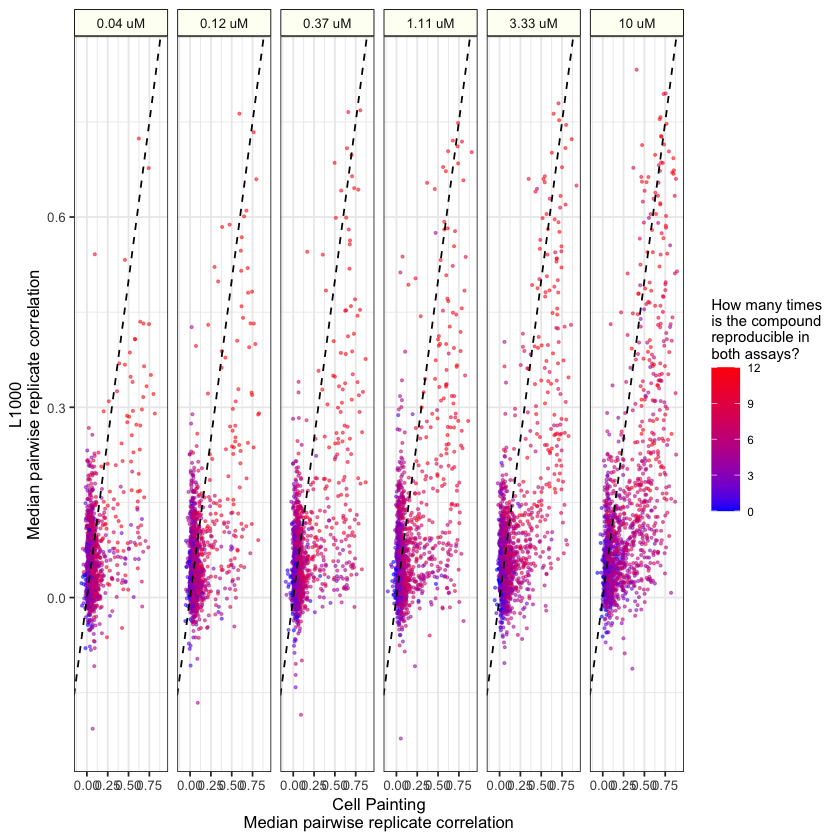

In [15]:
panel_b_gg <- (
    ggplot(
        pr_summary_df %>%
            # Remove compounds measured in different wells inconsistently
            dplyr::filter(!(compound %in% c("dexamethasone", "temsirolimus"))),
        aes(x = median_pairwise_correlation_cp, y = median_pairwise_correlation_l1000))
    + geom_point(aes(color = total_reproducible), size = 0.5, alpha = 0.5)
    + facet_grid("~dose")
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + figure_theme
    + scale_color_gradient("How many times\nis the compound\nreproducible in\nboth assays?", low = "blue", high = "red")
    + xlab("Cell Painting\nMedian pairwise replicate correlation")
    + ylab("L1000\nMedian pairwise replicate correlation")
)

panel_b_gg

## Panel C - Percent replicating summary

Which compounds pass the null distribution threshold?

In [16]:
significant_compounds_df <- pr_summary_df %>%
    dplyr::select(compound, well, dose, pass_thresh_cp, pass_thresh_l1000, pass_both)

total_compounds <- length(unique(significant_compounds_df$compound))
print(total_compounds)

head(significant_compounds_df, 3)

[1] 1256


compound,well,dose,pass_thresh_cp,pass_thresh_l1000,pass_both
<chr>,<chr>,<fct>,<lgl>,<lgl>,<lgl>
17-hydroxyprogesterone-caproate,N18,0.04 uM,TRUE,FALSE,FALSE
17-hydroxyprogesterone-caproate,N17,0.12 uM,TRUE,FALSE,FALSE
17-hydroxyprogesterone-caproate,N16,0.37 uM,TRUE,FALSE,FALSE


In [17]:
pass_thresh_summary_df <- significant_compounds_df %>%
    dplyr::group_by(dose) %>%
    dplyr::mutate(
        num_pass_cellpainting = sum(pass_thresh_cp),
        num_pass_l1000 = sum(pass_thresh_l1000),
        num_pass_both = sum(pass_both)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(dose, num_pass_cellpainting, num_pass_l1000, num_pass_both) %>%
    dplyr::distinct() %>%
    dplyr::mutate(
        unique_pass_cellpainting = num_pass_cellpainting - num_pass_both,
        unique_pass_l1000 = num_pass_l1000 - num_pass_both
    )

pass_thresh_summary_df

dose,num_pass_cellpainting,num_pass_l1000,num_pass_both,unique_pass_cellpainting,unique_pass_l1000
<fct>,<int>,<int>,<int>,<int>,<int>
0.04 uM,712,198,130,582,68
0.12 uM,703,216,145,558,71
0.37 uM,767,243,171,596,72
1.11 uM,829,283,219,610,64
3.33 uM,926,336,277,649,59
10 uM,1040,441,419,621,22


In [18]:
# Prep data and text for plotting
cell_painting_rect <- pass_thresh_summary_df %>%
    dplyr::select(dose, num_pass_cellpainting, unique_pass_cellpainting, num_pass_both) %>%
    dplyr::rename(c(ymax_bar = num_pass_cellpainting, unique_pass = unique_pass_cellpainting)) %>%
    dplyr::mutate(
        ymin_bar = 0,
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "Cell Painting",
        label_text_y = 300
    )

l1000_rect <- pass_thresh_summary_df %>%
    dplyr::mutate(ymax_bar = num_pass_cellpainting + unique_pass_l1000) %>%
    dplyr::select(dose, ymax_bar, unique_pass_cellpainting, unique_pass_l1000, num_pass_both) %>%
    dplyr::rename(c(ymin_bar = unique_pass_cellpainting, unique_pass = unique_pass_l1000)) %>%
    dplyr::mutate(
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "L1000",
        label_text_y = ymax_bar - 25
    )

full_rect <- dplyr::bind_rows(cell_painting_rect, l1000_rect)

num_pass_both_text <- full_rect %>%
    dplyr::filter(assay == "Cell Painting") %>%
    dplyr::select(dose, xmin_bar, ymax_bar, num_pass_both) %>%
    dplyr::left_join(
        full_rect %>%
            dplyr::filter(assay == "L1000") %>%
            dplyr::select(dose, ymin_bar) %>%
            dplyr::rename(c(ymin_l1000_bar = ymin_bar)),
        by = "dose"
    ) %>%
    dplyr::mutate(label_text_y = ymin_l1000_bar + (num_pass_both / 2))

# What percentage of compounds passed the threshold?
percentile_pass_df <- pass_thresh_summary_df %>%
    dplyr::mutate(
        num_pass_total = unique_pass_l1000 + unique_pass_cellpainting + num_pass_both,
        num_pass_percentile = paste("Total:\n", round(num_pass_total / total_compounds, 2) * 100, "%")
    ) %>%
    dplyr::select(dose, num_pass_percentile, num_pass_total)

# Prep legend order
full_rect <- full_rect %>%
    dplyr::add_row(
        dose = NA,
        ymax_bar = NA,
        unique_pass = NA,
        num_pass_both = NA,
        ymin_bar = NA,
        xmin_bar = NA,
        xmax_bar = NA,
        assay = "Both",
        label_text_y = NA
    ) %>%
    dplyr::left_join(percentile_pass_df, by = "dose")

full_rect$assay <- factor(full_rect$assay, levels = c("L1000", "Both", "Cell Painting"))

Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


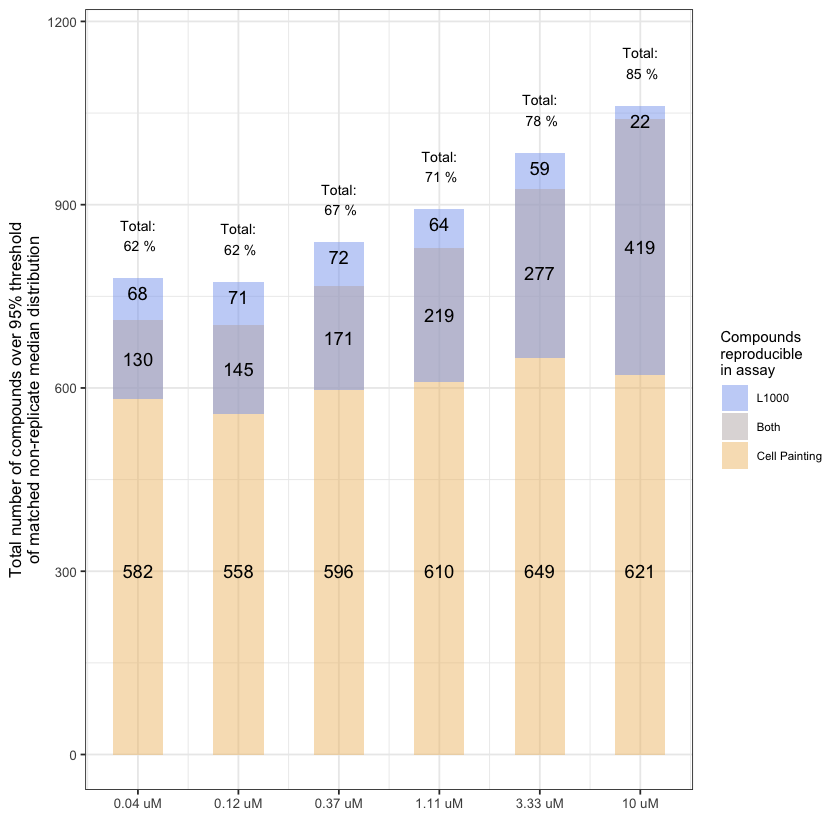

In [ ]:
updated_assay_colors <- c(assay_colors, "Both" = "#BDB4B4")

panel_c_gg <- (
    ggplot(full_rect)
    + geom_rect(aes(fill = assay, ymin = ymin_bar, ymax = ymax_bar, xmin = xmin_bar, xmax = xmax_bar), alpha = 0.5)
    + geom_text(aes(x = xmin_bar + 0.5, y = label_text_y, label = unique_pass))
    + geom_text(data = num_pass_both_text, aes(x = xmin_bar + 0.5, y = label_text_y, label = num_pass_both))
    # Select only L1000 below to not duplicate text
    + geom_text(
        data = full_rect %>% dplyr::filter(assay == "L1000"),
        aes(x = xmin_bar + 0.5, y = ymax_bar + 70, label = num_pass_percentile),
        size = 3
    )
    + scale_fill_manual("Compounds\nreproducible\nin assay", values = updated_assay_colors)
    + theme_bw()
    + figure_theme
    + scale_x_continuous(labels = num_pass_both_text$dose, breaks = seq(0.5, length(num_pass_both_text$dose) * 2, 2))
    + ylab("Total number of compounds over 95% threshold\nof matched non-replicate median distribution")
    + xlab("")
    + ylim(0, max(full_rect$num_pass_total, na.rm = TRUE) + 100)

)

panel_c_gg

## Compile and save Figure 1

Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


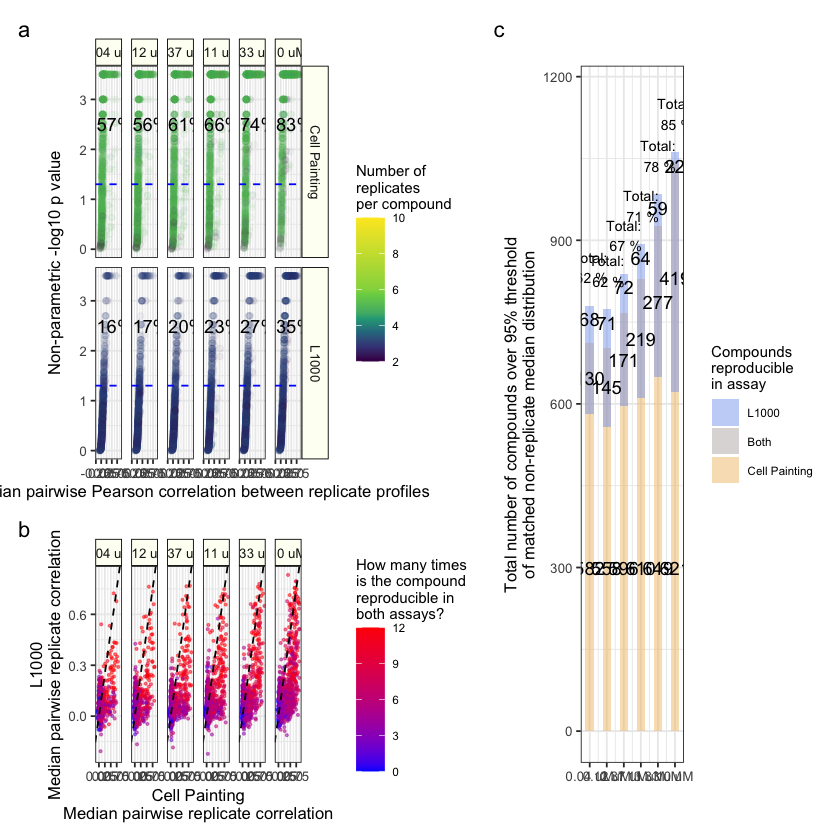

In [20]:
left_panel <- (panel_a_gg / panel_b_gg) + plot_layout(heights = c(2, 1))

figure_1_gg <- (
    ( left_panel | panel_c_gg)
    + plot_layout(widths = c(2, 1))
    + plot_annotation(tag_levels = "a")
)

for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    ggplot2::ggsave(output_file, figure_1_gg, width = 16, height = 6, dpi = 500)
}

figure_1_gg